# Project Title
*Johnny Antoun*, *Jackie Du*, *Richard Fremgen*, *Jose Pilego San Martin*

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

from plot_fxns import draw_soccer_pitch
from main import make_angle, make_distance

## Introduction

Soccer. Football. Fútbol. Fußball. However you pronounce the sport, soccer is widely regarded as the world’s most popular, with an estimated 4 billion fans across the globe. At the center of the men’s sport is the FIFA World Cup, an international quadrennial soccer competition where over 200 countries compete to qualify for one of the 32 spots that make the final tournament. This year being a World Cup year, coupled with our team members being avid fans of the game was the driving motivation for deciding to center this project around the analysis of a soccer dataset. The data used in this project is taken from an opensource project that created soccer logs to record every spatio-temporal match event that took place during the 2017-2018 club soccer seasons in England, France, Germany, Spain, and Italy. For every league game that occurred, each individual match event (e.g., shots, fouls, passes, duels) was recorded, along with the time and location on the pitch for which it took place. From this data, one can begin to deduce analytically how a particular team or league strategize and score goals. 

On a fundamental level, a soccer match is won by simply scoring more goals than your opponent. Thus, gametime tactics revolve around increasing a team’s probability of scoring, as player position and angle relative to the opposing goal are imperative when trying to maximize the odds of one scoring. Due to the immense dimensions of a soccer goal (8 ft by 24 ft), professional goalkeepers are trained to cut off or reduce the angle when an opposing player has the ball near the penalty area. Watch any professional goalkeeper play and you will see that they constantly adjust their position and angle relative to the play, rather than just stand on the goal line. With that in mind, our team was first interested in building an expected goals model to calculate the likelihood of scoring from different areas and angles on the pitch. This model could then be used to compare player and team performance for the given season. 

While goals in soccer are usually the most memorable parts of the game, passes are the connective tissue that create all goal scoring opportunities. It is widely known that different countries historically employ different methodologies of play and passing styles to best increase their chances of winning. The World Cup is the best evidence of such a feat, a match between England vs. Spain will reveal a multitude of differences between attacking styles and the types of passes made. A generic comparison of the different styles is below:
* **England**: less reliance on technique and more focus on physicality, with emphasis on long balls and set pieces.

* **Italy**: generally slower and tactical with older players; heavy emphasis on good defensive play.

* **Germany**: efficient, attacking football; teams are generally well-organized, professional, resourceful, and clinical.

* **Spain**: emphasizes keeping possession and creating space through movement. Generally the players in Spain have more time on the ball, allowing them to show the technical side of their game. 

* **France**: mix of the different styles of play of the other top 4 leagues.

While collecting data on each international's team game performance is one approach to validate whether a particular country truly plays a particular style of play, the problem with international soccer is that it happens so infrequently, making data collection a challenge to obtain an adequate sample size. Rather than trying to extrapolate from only a handful of games for each country, we decided to use the soccer log dataset to evaluate differences with how each league plays the game from a passing perspective. Then we can observe whether or not such passing patterns for each league coincide with the traditional tactics employed by the native country style of play. Using the league data provides an adequate sample size for comparison, since each leagues consists for 18 or 20 teams, that each play one another twice a season, all of which is collected in our dataset.

## Expected Goals Model

Expected goals is a statistical measure that tries to give a more fair assessment than raw scored goals. Since soccer is a low-scoring sport, the final result is often not a good summary of how the game developed.

An expected goals model assigns a probability score to each shot. This score approximates the probability of the given shot resulting in a goal. With these probability scores, analysts can draw stronger conclusions on team or individual performance.

### Data Cleaning

We use the event data to build the model. First, we filter for shots and extract information on whether each shot was a goal or not. This information is contained in the `tags` column, which also has additional shot characteristics like whether the shot was a header or not, with which foot the player took the shot, if the shot originated from a counter attack, etc.

Based on the shot coordinates, we create two additional features. First, we calculate the distance from the shot origin to the center of the goal. We also calculate the angle between the shot origin and the inner box. Intuitively, a small angle means that the player did not have a clear view of the goal. We do the angle calculation with the inner box because we do not know the positions of the posts in the pitch and the angle defined with the inner box is similar to the angle defined with the goal (in a statistical sense, at least).

The cleaning is done in the file `dt_shots.py` and this file imports the function `make_shot_df()` in `main.py`.

In [2]:
dt_shots = pd.read_pickle('data/processed/dt_shots.pkl')
# Convert coordinates to use the draw_pitch() function
dt_shots['start_x'] = dt_shots['start_x']/105 * 120
dt_shots['start_y'] = dt_shots['start_y']/68 * 90

with open("data/players.json", encoding="unicode_escape") as f:
    df_players = pd.read_json(f.read())
    
df_players = df_players.rename(columns={'wyId': 'playerId'})

### Exploratory Data Analysis

First, we look at all the shots taken, colored by whether they were goals or not. We can see that the majority of shots are not goals (as expected) and that most of the shots are taken inside the last 75% of the pitch.

There are some outlying shots outside the point cloud. It is interesting to note that many of the shots that are taken from very far away result in goals. This could be because the player takes a shot knowing that the goalkeeper is out of position, usually in the late minutes of the match when the goalkeeper goes to the opponent box in a desperate try to tie the game. For this reason, we use only shots that are taken inside the last 70% of the pitch.

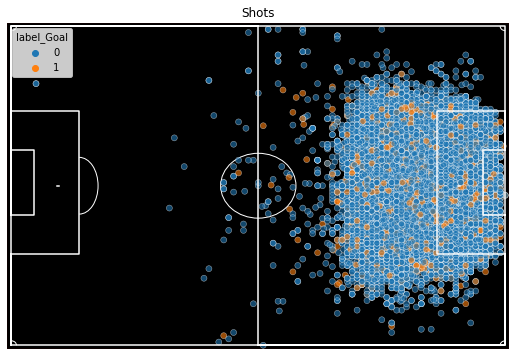

In [3]:
draw_soccer_pitch()
fig = sns.scatterplot(
    x='start_x',
    y='start_y',
    data=dt_shots,
    hue='label_Goal',
    alpha=0.6
)
fig.set_title('Shots')
plt.show()

We now look at the distribution of distance and angle, grouped by whether or not the shot is a goal. There are no obvious differences in the shape of the distributions.

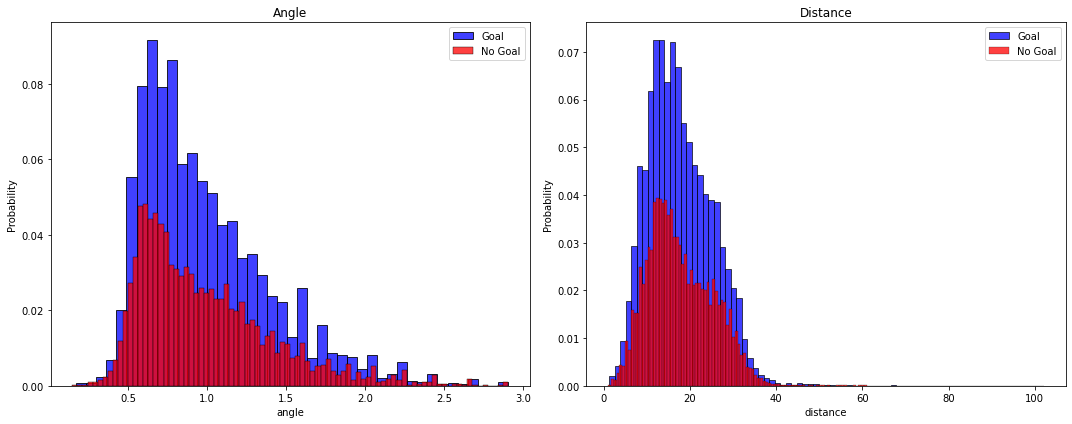

In [4]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 1]['angle'],
    color='b',
    stat='probability'
)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 0]['angle'],
    color='r',
    stat='probability'
)
plt.title('Angle')
plt.legend(labels=['Goal', 'No Goal'])
plt.subplot(1, 2, 2)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 1]['distance'],
    color='b',
    stat='probability'
)
sns.histplot(
    dt_shots[dt_shots['label_Goal'] == 0]['distance'],
    color='r',
    stat='probability'
)
plt.title('Distance')
plt.legend(labels=['Goal', 'No Goal'])
plt.tight_layout()
plt.show()

As a sanity check, we plot the shots colored by the angle (in radians). As expected, we see that shots that are closer to the goal and closer to the middle of the pitch (vertically) have larger angles than those further away or to the sides.

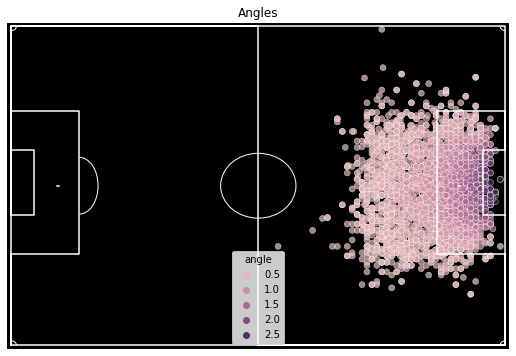

In [5]:
draw_soccer_pitch()
sns.scatterplot(
    data=dt_shots.iloc[1:3000, :], x='start_x', y='start_y', hue='angle', alpha=0.7
)
plt.title('Angles')
plt.show()

### Model

Since we expect non-linear interactions between the variables, we use a random forest to model the probabilities. We set it up as a binary classification task where the response is whether or not the shot was a goal. To evaluate the model we use the area under the ROC curve because we are more interested in the probability scores than in the actual classification labels.

We split the data into a training and a test set based on a stratified sample. We stratify because no-goals are much more prevalent in the data. To set the hyperparameters we use stratified k-fold cross validation and a grid search. We only show the final model here, but the complete procedure can be found in the `xg_model.py` file.

In [6]:
# Select relevant features
dt_shots = dt_shots[[
    'start_x', 'start_y', 'label_Left', 'label_Right', 'label_counter_attack',
    'label_head/body', 'label_interception', 'angle', 'distance', 'label_Goal'
]].dropna()

# Exclude shots taken from too far away
dt_shots = dt_shots[dt_shots['start_x'] > 70*105.0/100.0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    dt_shots.drop('label_Goal', axis=1), dt_shots.label_Goal, test_size=0.2,
    random_state=42,
    stratify=dt_shots.label_Goal
)

In [7]:
# Final model after cross-validation
final_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    max_features=9,
    n_jobs=2,
    min_samples_split=500,
    random_state=42,
    verbose=0
)

final_rf_fit = final_rf.fit(X_train, y_train)

The model achieves an AUC-ROC of 0.71 which is much better than random guessing and better than we got with other modeling approaches like logistic regression.

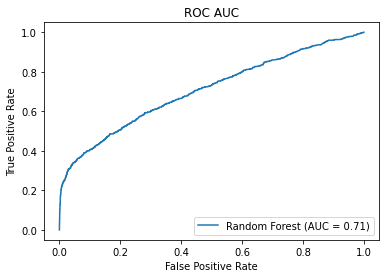

In [8]:
probs = final_rf_fit.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest'
).plot()
plt.title("ROC AUC")
plt.show()

We also show the feature importance plot. We see that the most important feature is the horizontal position in the pitch, followed by the angle, vertical position, and distance. We decided to include both the coordinates and distance/angle because we expected the effect of angle and distance to change based on where on the pitch the shooter is located.

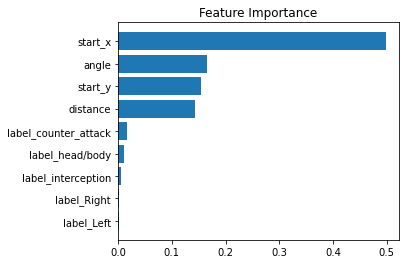

In [9]:
rf_importance = final_rf_fit.feature_importances_
df_importance = pd.DataFrame({'variable': X_train.columns, 'importance': rf_importance}).\
    sort_values('importance')

plt.barh(np.arange(len(df_importance.variable)), df_importance.importance)
plt.yticks(np.arange(len(df_importance.variable)), df_importance.variable)
plt.subplots_adjust(left=0.25)
plt.title("Feature Importance")
plt.show()

We can use the model to make probability maps for scoring on the pitch. We show a contour plot for shots and headers in a no-counter attack situation. We can see that the contours form curves around the goal as expected with distance and angle features.

For the shot plot, we see some vertical stripes of high scoring probability. This is because many of the goals in the original data were located exactly on this x-coordinate (rounded in the original dataset). In both plots we see some outlying zones far from the goal. These arise because the data has few observations in those areas and most of the observations are goals (no one would attempt a header from 3/4 of the pitch if the goalkeeper is in position). Therefore, conclusions must be made carefully.

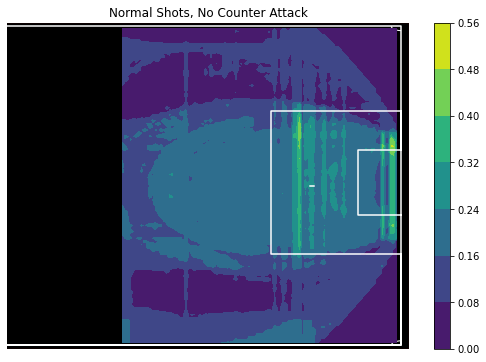

In [10]:
x_plot = np.linspace((70+0.5)*1.05, 105-0.5, 100)
y_plot = np.linspace(0+0.5, 68-0.5, 100)
xx, yy = np.meshgrid(x_plot, y_plot)
dt_plot = pd.DataFrame({'start_x': xx.flatten(), 'start_y': yy.flatten()})
dt_plot['label_Left'] = 0
dt_plot['label_Right'] = 1
dt_plot['label_counter_attack'] = 0
dt_plot['label_head/body'] = 0
dt_plot['label_interception'] = 0
dt_plot['angle'] = make_angle(dt_plot.start_x, dt_plot.start_y)
dt_plot['distance'] = make_distance(dt_plot.start_x, dt_plot.start_y)
dt_plot['goal_prob'] = final_rf_fit.predict_proba(dt_plot)[:, 1]
dt_plot['goal_prob'] = dt_plot.apply(lambda x: x['goal_prob'] if x['angle'] > 0.145 else 0, axis=1)
dt_plot['start_x'] = dt_plot['start_x']/105 * 120
dt_plot['start_y'] = dt_plot['start_y']/68 * 90

xg_array = np.array(dt_plot.goal_prob).reshape((100, 100))

draw_soccer_pitch()
plt.contourf(
    np.array(dt_plot.start_x).reshape((100, 100)),
    np.array(dt_plot.start_y).reshape((100, 100)),
    xg_array
)
plt.colorbar()
plt.title("Normal Shots, No Counter Attack")
plt.xlim(left=70)
plt.show()

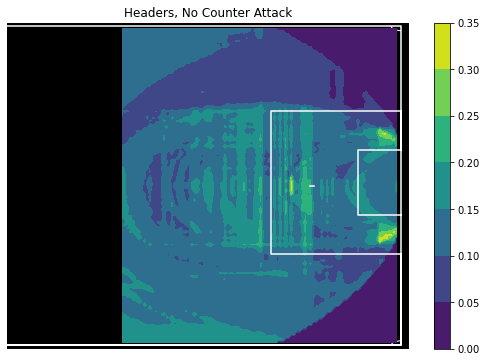

In [11]:
dt_plot = dt_plot.drop('goal_prob', axis=1)
dt_plot['label_head/body'] = 1
dt_plot['label_counter_attack'] = 0
dt_plot['goal_prob'] = final_rf_fit.predict_proba(dt_plot)[:, 1]
dt_plot['goal_prob'] = dt_plot.apply(lambda x: x['goal_prob'] if x['angle'] > 0.195 else 0, axis=1)

xg_array = np.array(dt_plot.goal_prob).reshape((100, 100))

draw_soccer_pitch()
plt.contourf(
    np.array(dt_plot.start_x).reshape((100, 100)),
    np.array(dt_plot.start_y).reshape((100, 100)),
    xg_array
)
plt.colorbar()
plt.title("Headers, No Counter Attack")
plt.xlim(left=70)

plt.show()

### Player and Team Analysis

We can look at what teams and players overperform or underperform their expected goals. Intuitively, a player that outscores his expected goals is a good forward because he get goals from low probability scoring situations. Similarly, a team that greatly outperforms expected goals may have very good strikers (or was very lucky during the season).

In [12]:
dt_shots = pd.read_pickle('data/processed/dt_shots.pkl').dropna()
dt_shots['start_x'] = dt_shots['start_x']/105 * 120
dt_shots['start_y'] = dt_shots['start_y']/68 * 90

rf_columns = [
    'start_x', 'start_y', 'label_Left', 'label_Right', 'label_counter_attack',
    'label_head/body', 'label_interception', 'angle', 'distance'
]

df_full = dt_shots.merge(df_players[['playerId', 'shortName']], on='playerId', how='left')
df_full['xg'] = final_rf_fit.predict_proba(df_full[rf_columns])[:, 1]

df_players_xg = df_full[['shortName', 'label_Goal', 'xg']].\
    groupby('shortName').\
    agg('sum').\
    sort_values('xg', ascending=False)

df_players_xg['diff'] = df_players_xg['label_Goal'] - df_players_xg['xg']

We show the top 15 performers. Most of these players are regarded as being the best forwards in the world, so the interpretation makes sense. We see some surprises like Iago Aspas and Cristhian Stuani, very good forwards that played in mid to low-table clubs in Spain.

We also see the bottom 15 performers. It is interesting to see that most of these players are not forwards, so their main role is not scoring goals. It is surprising to see Lorenzo Insigne, a very good Italian forward, on the list. However, diving deeper into his stats we found that he had a bad scoring season in 2017-2018, which is the season we use in the project.

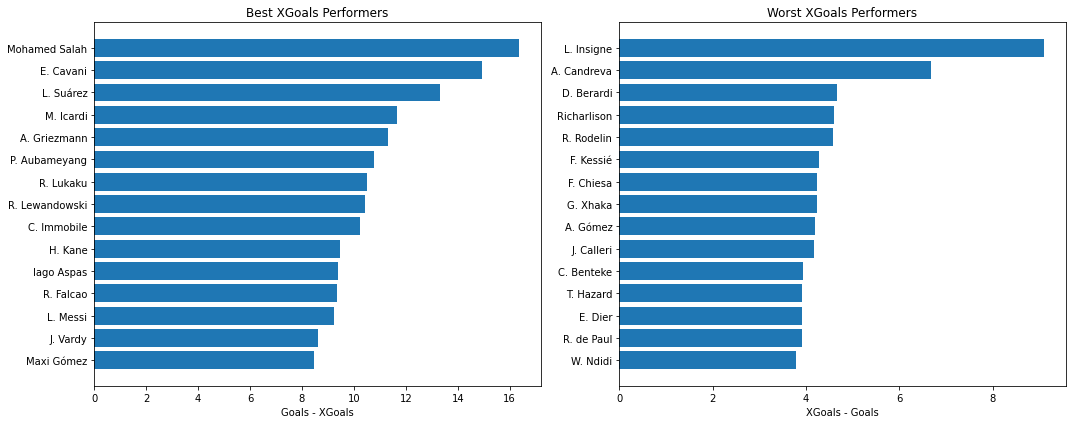

In [13]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_players_xg.sort_values('diff', ascending=True).iloc[-15:, 2]
)
plt.yticks(range(15), df_players_xg.sort_values('diff', ascending=True).iloc[-15:, :].index)
plt.title('Best XGoals Performers')
plt.xlabel('Goals - XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    abs(df_players_xg.sort_values('diff', ascending=False).iloc[-15:, 2])
)
plt.yticks(range(15), df_players_xg.sort_values('diff', ascending=False).iloc[-15:, :].index)
plt.title('Worst XGoals Performers')
plt.xlabel('XGoals - Goals')
plt.tight_layout()
plt.show()

In [14]:
id_comp = pd.read_pickle('data/processed/dt_teams.pkl')

df_teams = df_full.merge(id_comp, on='id', how='left')
df_clubs = df_teams.loc[
    (df_teams['competition'] != 'European_Championship') & (df_teams['competition'] != 'World_Cup')
]
df_wc = df_teams[df_teams['competition'] == 'World_Cup']
df_euros = df_teams[df_teams['competition'] == 'European_Championship']

df_clubs_xg = df_clubs[['label_Goal', 'xg', 'teamId']].\
    groupby('teamId').\
    agg('sum').\
    reset_index().\
    rename(columns={'index': 'teamId'})

with open('data/teams.json', encoding='unicode_escape') as f:
    teams_id = pd.read_json(f.read())
    teams_id = teams_id[['name', 'wyId']]
    teams_id = teams_id.rename(columns={'wyId': 'teamId'})
    
df_clubs_full = df_clubs_xg.merge(teams_id, on='teamId', how='left')
df_clubs_full['diff'] = df_clubs_full['label_Goal'] - df_clubs_full['xg']

We look at the best teams in terms of expected goals and the teams that outscored their expected goals by the largest amount. We notice again that the best teams in terms of expected goals are some of the best known clubs that usually dominate their domestic competitions. It is also interesting to note that Barcelona was the team with the largest difference between goals and expected goals. As we saw before, Barcelona had two of the best forwards in Messi and Luis Suarez. They won the Spanish League that year.

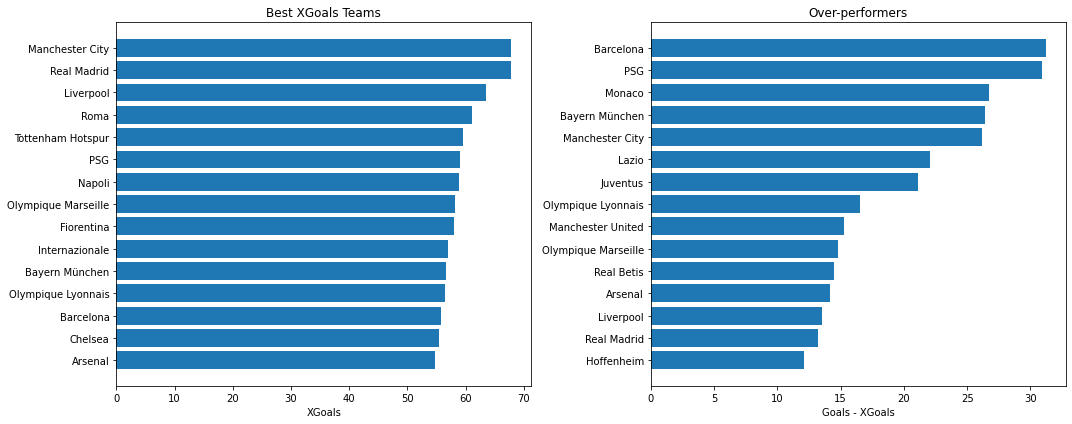

In [15]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_clubs_full.sort_values('xg', ascending=True).iloc[-15:, 2]
)
plt.yticks(range(15), df_clubs_full.sort_values('xg', ascending=True).iloc[-15:, :].name)
plt.title('Best XGoals Teams')
plt.xlabel('XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    df_clubs_full.sort_values('diff', ascending=True).iloc[-15:, 4]
)
plt.yticks(range(15), df_clubs_full.sort_values('diff', ascending=True).iloc[-15:, :].name)
plt.title('Over-performers')
plt.xlabel('Goals - XGoals')
plt.tight_layout()
plt.show()

Finally, we look at the worst teams in terms of expected goals. Some of the teams included in the worst 15 ended up being relegated at the end of the season. Some examples are Swansea City, Las Palmas, Hellas Verona, Hamburger SC, and Wolfsburg (Wolfsburg was not really relegated since they later won the relegation playoff).

The graph of underperformers also conveys some interesting information. We can see that Las Palmas was simultaneously one of the worst expected goals team and one of the worst underperformes, a recipe for disaster. Fiorentina show up in the underperformers and they also show up in the graph of best expected goals teams. We cannot help but wonder what would have been of Fiorentina with better forwards since that season they missed classification to European competitions by only 3 points. We also note that many relegated teams show up in the underperformers graph like Las Palmas, Benevento, Malaga, Toulouse, Hamburger, and Deportivo La Coruna.

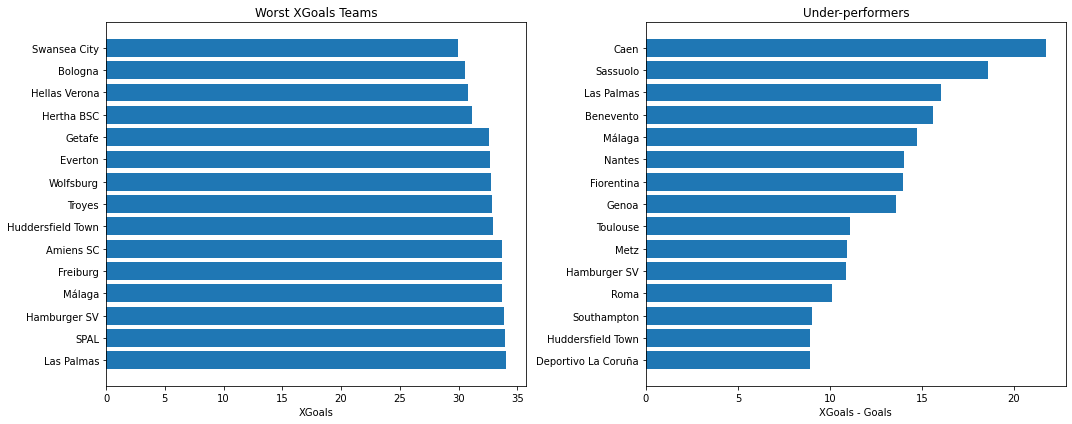

In [16]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.barh(
    range(15),
    df_clubs_full.sort_values('xg', ascending=False).iloc[-15:, 2]
)
plt.yticks(range(15), df_clubs_full.sort_values('xg', ascending=False).iloc[-15:, :].name)
plt.title('Worst XGoals Teams')
plt.xlabel('XGoals')

plt.subplot(1, 2, 2)
plt.barh(
    range(15),
    abs(df_clubs_full.sort_values('diff', ascending=False).iloc[-15:, 4])
)
plt.yticks(range(15), df_clubs_full.sort_values('diff', ascending=False).iloc[-15:, :].name)
plt.title('Under-performers')
plt.xlabel('XGoals - Goals')
plt.tight_layout()
plt.show()